<a href="https://colab.research.google.com/github/taniasuchi07/Technical-Assessment/blob/main/Fraud_Healthcare1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [ ]:
credit = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard_2023.csv")   # Credit Card Fraud Dataset (Financial Domain)
print(credit.head())
print(credit.shape)

   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28    Amount  C

In [ ]:
health = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/combined_nhis_dataset_with_fraud_types (1).csv")        #  Healthcare Provider Fraud Dataset (Healthcare Domain)
print(health.head())
print(health.shape)

   Patient ID   AGE GENDER DATE OF ENCOUNTER DATE OF DISCHARGE  Amount Billed  \
0           1  25.0      F        2025-02-11        2025-02-11        16800.0   
1           2  30.0      M        2025-02-13        2025-02-13         6300.0   
2           3  35.0      M        2025-02-13        2025-02-13         6160.0   
3           4  48.0      M        2025-02-18        2025-02-18            0.0   
4           5  58.0      F        2025-02-18        2025-02-18         8400.0   

                             DIAGNOSIS       FRAUD_TYPE  
0                           CYESIS LMP  Phantom Billing  
1                        WAX IMPACTION  Wrong Diagnosis  
2                           CYESIS LMP  Wrong Diagnosis  
3  TONSILITIS OBSTRUCTIVE SLEEP APEANA   Ghost Enrollee  
4                     REFRACTIVE ERROR         No Fraud  
(20388, 8)


**Preprocessing**

In [ ]:
scaler = StandardScaler()            #  Credit Card Scaling
credit['scaled_amount'] = scaler.fit_transform(credit[['Amount']])


# Drop the original 'Amount' column, as 'Time' is not present to be dropped.
credit = credit.drop(['Amount'], axis=1)

**Encoder**

In [ ]:
health = health.dropna(axis=1, thresh=0.5 * len(health))              # Healthcare Dataset Cleaning
health = health.fillna(0)

In [ ]:
health.dtypes

,0
Patient ID,int64
AGE,float64
GENDER,object
DATE OF ENCOUNTER,object
DATE OF DISCHARGE,object
Amount Billed,float64
DIAGNOSIS,object
FRAUD_TYPE,object


In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

# Convert columns to string type to handle mixed types (e.g., 0 from fillna and date strings)
health['GENDER'] = health['GENDER'].astype(str)
health['DATE OF ENCOUNTER'] = health['DATE OF ENCOUNTER'].astype(str)
health['DATE OF DISCHARGE'] = health['DATE OF DISCHARGE'].astype(str)
health['DIAGNOSIS'] = health['DIAGNOSIS'].astype(str)
health['FRAUD_TYPE'] = health['FRAUD_TYPE'].astype(str)

health['Gender']= label_encoder.fit_transform(health['GENDER'])
health['Date of Encounter']= label_encoder.fit_transform(health['DATE OF ENCOUNTER'])
health['Date of discharge']= label_encoder.fit_transform(health['DATE OF DISCHARGE'])
health['Diagnosis']= label_encoder.fit_transform(health['DIAGNOSIS'])
health['Fraud Type']= label_encoder.fit_transform(health['FRAUD_TYPE'])

In [ ]:
health

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE,Gender,Date of Encounter,Date of discharge,Diagnosis,Fraud Type
0,1,25.0,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing,0,2262,2231,415,2
1,2,30.0,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis,2,2265,2234,1761,3
2,3,35.0,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis,2,2265,2234,415,3
3,4,48.0,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee,2,2273,2243,1639,0
4,5,58.0,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud,0,2273,2243,1374,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20383,19996,36.0,F,2024-06-27 00:00:00,2020-10-18 00:00:00,18562.0,HHDX HEART FAILURE HTN,Phantom Billing,0,1861,270,708,2
20384,19997,50.0,M,2020-07-11 00:00:00,2020-11-21 00:00:00,11893.0,HUMERUS FRACTURE,No Fraud,2,180,301,823,1
20385,19998,29.0,M,2023-07-06 00:00:00,2021-10-13 00:00:00,5980.0,EARLY CYESIS IN A KNOWN PCOS & DM Pt WITH POOR...,Wrong Diagnosis,2,1255,601,530,3
20386,19999,43.0,M,2024-03-24 00:00:00,2023-11-06 00:00:00,10696.0,SOLITARY RGT UPPER CERVICAL LYMPH ADENOPHATY C...,Phantom Billing,2,1692,1430,1560,2


In [ ]:
health['Fraud Type'].unique()

array([2, 3, 0, 1])

In [ ]:
health= health.drop(['GENDER', 'DATE OF ENCOUNTER', 'DATE OF DISCHARGE', 'DIAGNOSIS', 'FRAUD_TYPE'], axis=1)

In [ ]:
health

,Patient ID,AGE,Amount Billed,Gender,Date of Encounter,Date of discharge,Diagnosis,Fraud Type
0,1,25.0,16800.0,0,2262,2231,415,2
1,2,30.0,6300.0,2,2265,2234,1761,3
2,3,35.0,6160.0,2,2265,2234,415,3
3,4,48.0,0.0,2,2273,2243,1639,0
4,5,58.0,8400.0,0,2273,2243,1374,1
...,...,...,...,...,...,...,...,...
20383,19996,36.0,18562.0,0,1861,270,708,2
20384,19997,50.0,11893.0,2,180,301,823,1
20385,19998,29.0,5980.0,2,1255,601,530,3
20386,19999,43.0,10696.0,2,1692,1430,1560,2


**Handling Imbalanced Data**

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [ ]:
X_fin = credit.drop('Class', axis=1)             #  Credit Card (SMOTE-ENN)
y_fin = credit['Class']

In [ ]:
X_hc = health.drop('Fraud Type', axis=1)                # Healthcare Dataset (SMOTE)
y_hc = health['Fraud Type']

In [ ]:
X_fin = credit.drop('Class', axis=1)             #  Credit Card (SMOTE-ENN)
y_fin = credit['Class']

smote = SMOTE (random_state=27)
X_fin_res, y_fin_res = smote.fit_resample(X_fin, y_fin)

print("Before:", y_fin.value_counts())
print("After:", y_fin_res.value_counts())

Before: Class
0    284315
1    284315
Name: count, dtype: int64
After: Class
0    284315
1    284315
Name: count, dtype: int64


In [ ]:
X_hc = health.drop('Fraud Type', axis=1)                # Healthcare Dataset (SMOTE)
y_hc = health['Fraud Type']

smote = SMOTE()
X_hc_res, y_hc_res = smote.fit_resample(X_hc, y_hc)

print("Before:", y_hc.value_counts())
print("After:", y_hc_res.value_counts())

Before: Fraud Type
1    11704
2     4233
0     4099
3      352
Name: count, dtype: int64
After: Fraud Type
2    11704
3    11704
0    11704
1    11704
Name: count, dtype: int64


**Train-Test Split**

In [ ]:
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(
    X_fin_res, y_fin_res, test_size=0.2, random_state=42
)


In [ ]:
X_train_hc, X_test_hc, y_train_hc, y_test_hc = train_test_split(
    X_hc_res, y_hc_res, test_size=0.2, random_state=42
)

**Machine Learning Models**

***Random Forest for Financial Fraud***

In [ ]:
from sklearn.ensemble import RandomForestClassifier                 # Credit Card Dataset
rfc=RandomForestClassifier()
rfc.fit(X_train_fin, y_train_fin)

RandomForestClassifier()

In [ ]:
y_pred_rf=rfc.predict(X_test_fin)
# Get prediction probabilities for AUC from RandomForestClassifier
pred_fin_rf_proba = rfc.predict_proba(X_test_fin)[:, 1]
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report (Random Forest):\n",classification_report(y_test_fin,y_pred_rf))
print("Confusion Matrix:\n",confusion_matrix(y_test_fin,y_pred_rf))
print("Training Score:\n",rfc.score(X_train_fin,y_train_fin)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test_fin,y_pred_rf))
print("R2 score is:\n",r2_score(y_test_fin,y_pred_rf))

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Confusion Matrix:
 [[56746     4]
 [   15 56961]]
Training Score:
 100.0
Mean Squared Error:
 0.0001670682165907532
R2 score is:
 0.999331724494555


In [ ]:
y_pred_rf_proba = rfc.predict_proba(X_test_fin)   # Needed for ROC

In [ ]:
print(accuracy_score(y_test_fin,y_pred_rf)*100)

99.98241387193781


**XGBoost for Financial Fraud**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost for Financial Fraud
xgb_fin = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

xgb_fin.fit(X_train_fin, y_train_fin)

# Predictions
pred_fin = xgb_fin.predict(X_test_fin)
pred_fin_proba = xgb_fin.predict_proba(X_test_fin)[:, 1]

# Evaluation
print("Classification Report (XGBoost)")
print(classification_report(y_test_fin, pred_fin))
print("AUC Score:", roc_auc_score(y_test_fin, pred_fin_proba))


Classification Report (XGBoost)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

AUC Score: 0.9999963932568563


In [ ]:
print(accuracy_score(y_test_fin, pred_fin)*100)

99.98417248474404


**SVM for Financial Fraud**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_fast = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(random_state=42))
])

svm_fast.fit(X_train_fin, y_train_fin)

pred_svm_fast = svm_fast.predict(X_test_fin)
# Get decision function scores for AUC from LinearSVC
pred_fin_svm_decision_scores = svm_fast.decision_function(X_test_fin)

print(classification_report(y_test_fin, pred_svm_fast))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



In [ ]:
print(accuracy_score(y_test_fin,pred_svm_fast)*100)

99.82062149376571


***Random Forest for Healthcare***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_hc, y_train_hc)               # Healthcare Dataset

RandomForestClassifier(n_estimators=200)

In [ ]:
y_pred_rf1=rfc.predict(X_test_hc)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report (Random Forest):\n",classification_report(y_test_hc,y_pred_rf1))
print("Confusion Matrix:\n",confusion_matrix(y_test_hc,y_pred_rf1))
print("Training Score:\n",rfc.score(X_train_hc,y_train_hc)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test_hc,y_pred_rf1))
print("R2 score is:\n",r2_score(y_test_hc,y_pred_rf1))

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2401
           1       0.99      0.95      0.97      2268
           2       0.99      1.00      0.99      2330
           3       0.96      0.99      0.97      2365

    accuracy                           0.98      9364
   macro avg       0.98      0.98      0.98      9364
weighted avg       0.98      0.98      0.98      9364

Confusion Matrix:
 [[2395    0    0    6]
 [   0 2157   25   86]
 [   0    2 2328    0]
 [   4   25    0 2336]]
Training Score:
 100.0
Mean Squared Error:
 0.05991029474583511
R2 score is:
 0.95274971200975


In [ ]:
y_pred_rf1_proba = rfc.predict_proba(X_test_hc)   # Needed for ROC

In [ ]:
print(accuracy_score(y_test_hc,y_pred_rf1)*100)

98.41947885519009


**XGBoost for Healthcare**

In [ ]:
from xgboost import XGBClassifier

# PCA (if dimensionality is large)
from sklearn.decomposition import PCA

# Adjust n_components to be less than or equal to the number of features (which is 7 for X_train_hc)
# For example, let's use 7 components to capture all variance, or a smaller number if dimensionality reduction is desired.
pca = PCA(n_components=7) # Changed from 30 to 7
X_train_hc_pca = pca.fit_transform(X_train_hc)
X_test_hc_pca = pca.transform(X_test_hc)

# XGBoost for Healthcare
xgb_hc = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    # eval_metric='logloss', # 'logloss' is for binary classification or for multi-class with appropriate labels
    n_jobs=-1,
    random_state=42
)

xgb_hc.fit(X_train_hc_pca, y_train_hc)

# Predictions
pred_hc = xgb_hc.predict(X_test_hc_pca)
# For multiclass AUC, predict_proba returns scores for each class
pred_hc_proba = xgb_hc.predict_proba(X_test_hc_pca)

# Evaluation
print("XGBoost Healthcare Dataset")
print(classification_report(y_test_hc, pred_hc))
# Calculate AUC score for multiclass using 'ovr' strategy
print("AUC Score:", roc_auc_score(y_test_hc, pred_hc_proba, multi_class='ovr', average='weighted'))

XGBoost Healthcare Dataset
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2401
           1       0.98      0.91      0.95      2268
           2       0.99      1.00      0.99      2330
           3       0.93      0.98      0.95      2365

    accuracy                           0.97      9364
   macro avg       0.97      0.97      0.97      9364
weighted avg       0.97      0.97      0.97      9364

AUC Score: 0.9982028646060903


In [ ]:
print(accuracy_score(y_test_hc,pred_hc)*100)

97.30884237505339


**SVM for Healthcare**

In [ ]:
from sklearn.svm import SVC # Import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# SVM Pipeline for Healthcare Fraud
svm_hc = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

svm_hc.fit(X_train_hc_pca, y_train_hc)

pred_hc_svm = svm_hc.predict(X_test_hc_pca)
# For multiclass AUC, predict_proba returns scores for each class
pred_hc_svm_proba = svm_hc.predict_proba(X_test_hc_pca)

print("SVM Healthcare Dataset")
print(classification_report(y_test_hc, pred_hc_svm))
# Calculate AUC score for multiclass using 'ovr' strategy
print("AUC Score:", roc_auc_score(y_test_hc, pred_hc_svm_proba, multi_class='ovr', average='weighted'))

SVM Healthcare Dataset
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2401
           1       0.76      0.61      0.68      2268
           2       0.84      0.87      0.86      2330
           3       0.71      0.75      0.73      2365

    accuracy                           0.81      9364
   macro avg       0.80      0.81      0.80      9364
weighted avg       0.81      0.81      0.80      9364

AUC Score: 0.9510238766490943


In [ ]:
print(accuracy_score(y_test_hc,pred_hc_svm)*100)

80.95899188381034


In [ ]:
results = {
    "Model": ["RandomForest-Fin", "XGBoost-Fin", "SVM-Fin", "XGBoost-HC", "SVM-HC"],
    "AUC": [
        roc_auc_score(y_test_fin, y_pred_rf), # AUC for Random Forest Financial
        roc_auc_score(y_test_fin, pred_fin_proba),    # AUC for XGBoost Financial
        roc_auc_score(y_test_fin, pred_fin_svm_decision_scores), # AUC for SVM Financial (using decision scores)
        roc_auc_score(y_test_hc, pred_hc_proba, multi_class='ovr', average='weighted'), # AUC for XGBoost Healthcare (multiclass)
        roc_auc_score(y_test_hc, pred_hc_svm_proba, multi_class='ovr', average='weighted')  # AUC for SVM Healthcare (multiclass)
    ]
}

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

              Model       AUC
0  RandomForest-Fin  0.999833
1       XGBoost-Fin  0.999996
2           SVM-Fin  0.999880
3        XGBoost-HC  0.998203
4            SVM-HC  0.951024


**Graphs**

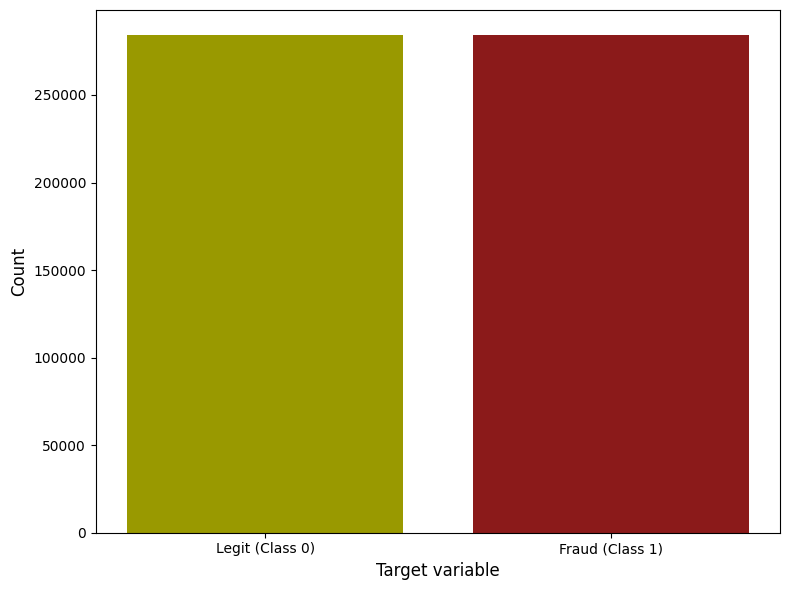

In [ ]:
import matplotlib.pyplot as plt

# Manually define the counts for each class
class_counts = {
    "Legit (Class 0)": 284315,  # Replace with your actual count for Class 0
    "Fraud (Class 1)": 284315      # Replace with your actual count for Class 1
}

# Extract labels and values from the dictionary
labels = list(class_counts.keys())
values = list(class_counts.values())

# Create a bar plot
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
plt.bar(labels, values, color=['#999900', '#8B1A1A'])  # Use different colors for better distinction

# Add title and labels
#plt.title("Credit Card Fraud Class Distribution", fontsize=12)
plt.xlabel("Target variable", fontsize=12)
plt.ylabel("Count", fontsize=12)


# Display the bar plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

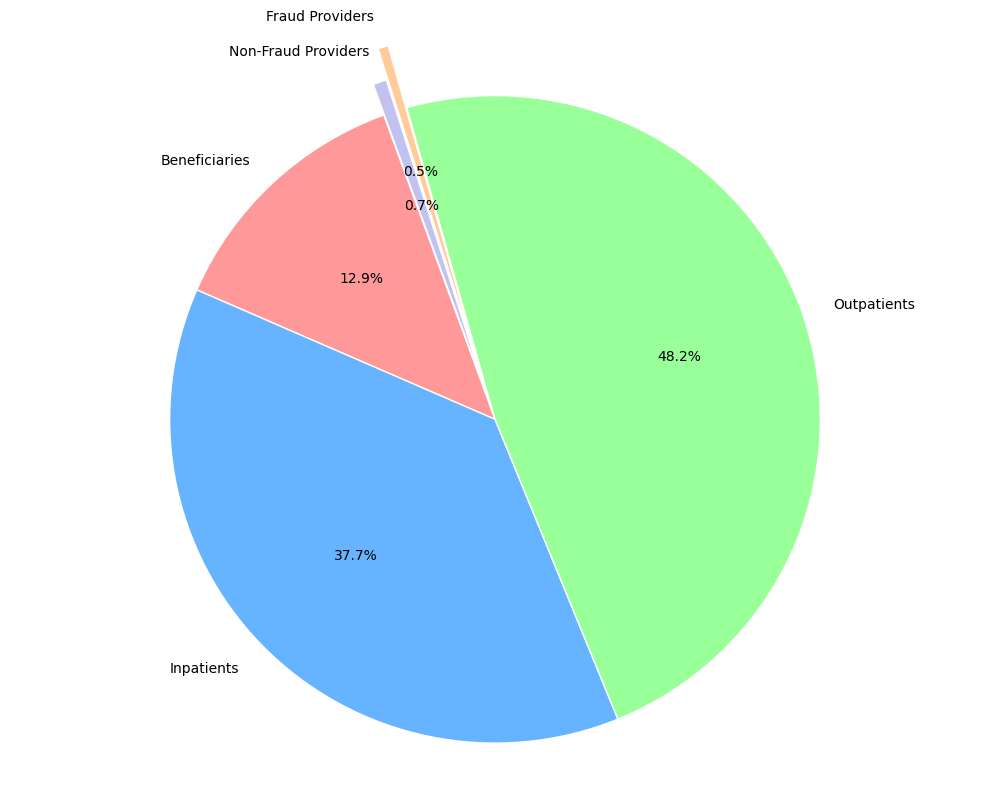

In [ ]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['Beneficiaries', 'Inpatients', 'Outpatients', 'Fraud Providers', 'Non-Fraud Providers']
sizes = [138556, 404983, 517737, 5534, 7216]

# Define colors for better visualization
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']
explode = [0, 0, 0, 0.2, 0.1]
# Create the pie chart
plt.figure(figsize=(10, 8))  # Set figure size
plt.pie(sizes, labels=labels,  colors=colors, explode = explode, autopct='%1.1f%%', startangle=110,
      wedgeprops = {"linewidth": 1, "edgecolor": "white"})



# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

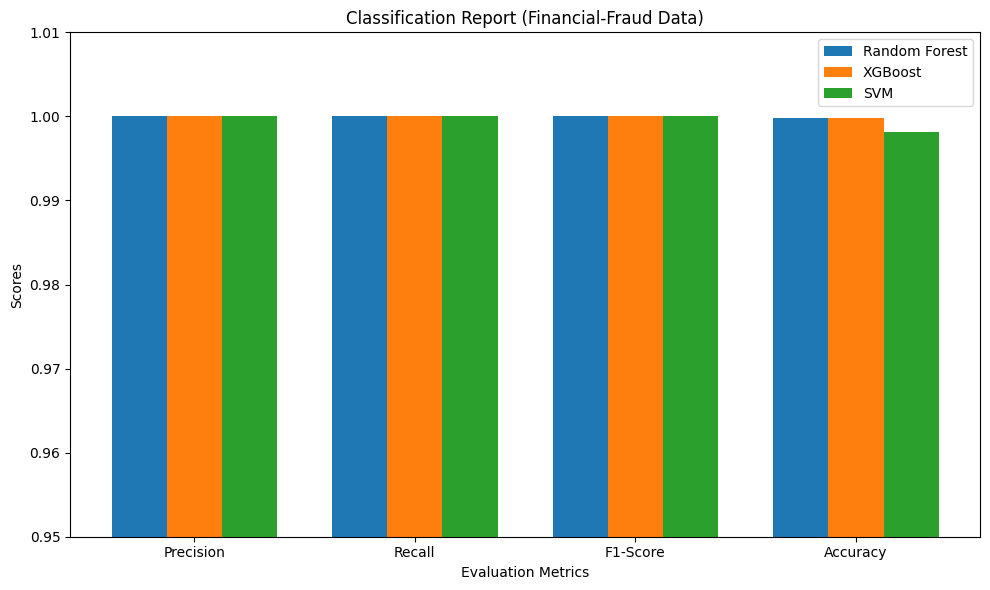

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Performance scores: Precision, Recall, F1-Score, Accuracy
scores = {
    'Random Forest': [1.00, 1.00, 1.00, 0.9998],
    'XGBoost': [1.00, 1.00, 1.00, 0.9998],
    'SVM': [1.00, 1.00, 1.00, 0.9982]
}

metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]

# Convert dict to array
model_names = list(scores.keys())
score_values = np.array(list(scores.values()))

# Create positions for bars
x = np.arange(len(metrics))
width = 0.25  # width of each bar

plt.figure(figsize=(10, 6))

plt.bar(x - width, score_values[0], width, label='Random Forest')
plt.bar(x, score_values[1], width, label='XGBoost')
plt.bar(x + width, score_values[2], width, label='SVM')

plt.xlabel("Evaluation Metrics")
plt.ylabel("Scores")
plt.title("Classification Report (Financial-Fraud Data)")
plt.xticks(x, metrics)
plt.ylim(0.95, 1.01)
plt.legend(bbox_to_anchor=(1,1), fontsize=10)


plt.tight_layout()
plt.show()

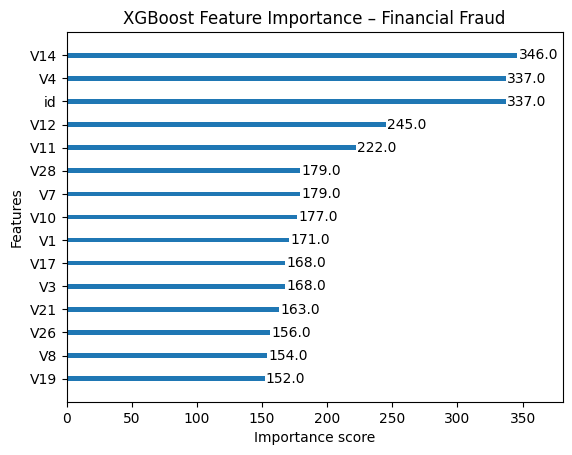

In [ ]:
import xgboost as xgb
xgb.plot_importance(xgb_fin, max_num_features=15)
plt.title("XGBoost Feature Importance – Financial Fraud")
plt.grid(False)
plt.show()

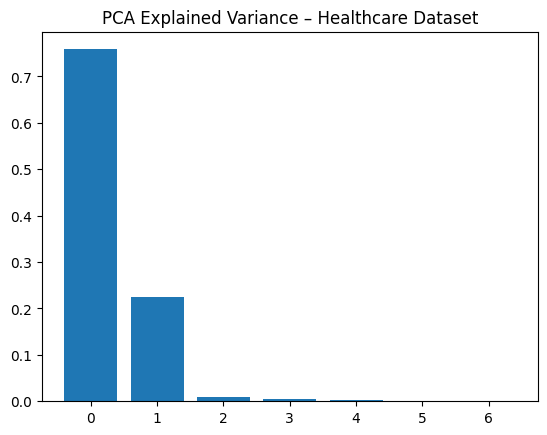

In [ ]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("PCA Explained Variance – Healthcare Dataset")
plt.show()

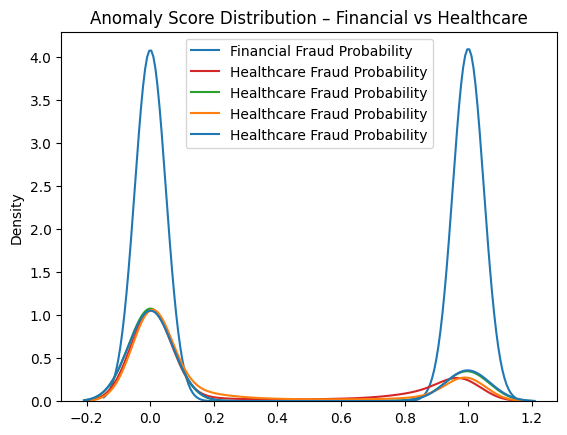

In [ ]:
sns.kdeplot(pred_fin_proba, label="Financial Fraud Probability")
sns.kdeplot(pred_hc_proba, label="Healthcare Fraud Probability")
plt.legend()
plt.title("Anomaly Score Distribution – Financial vs Healthcare")
plt.show()


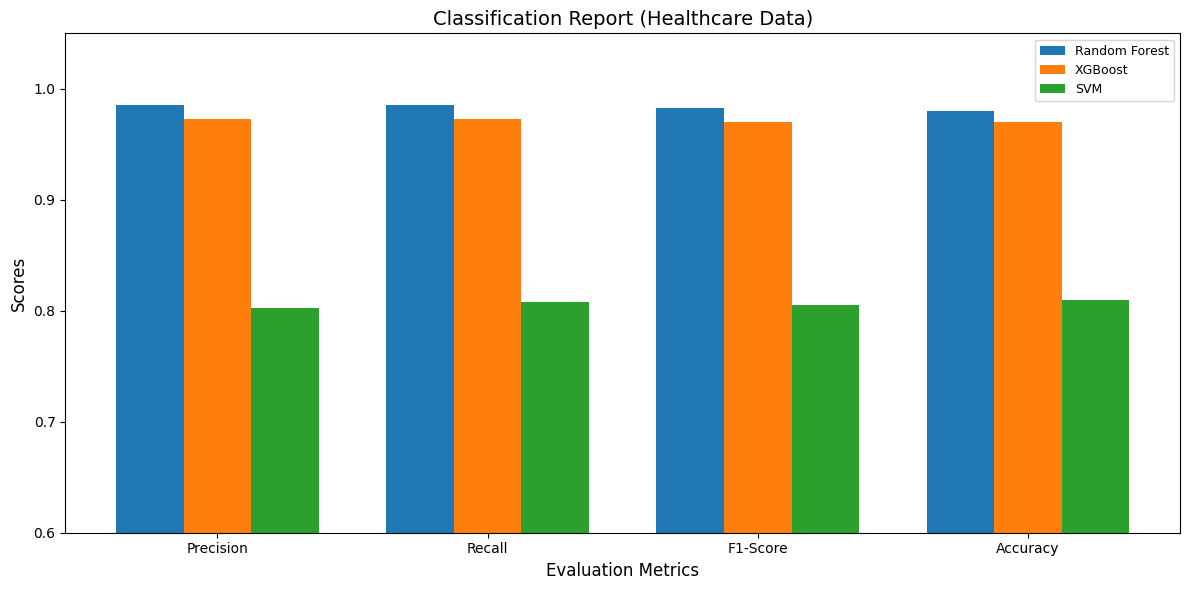

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Force white background
plt.style.use('default')

# Macro-averaged scores (from your classification reports)
scores = {
    "Random Forest": [0.9850, 0.9850, 0.9825, 0.98],
    "XGBoost": [0.9725, 0.9725, 0.9700, 0.97],
    "SVM": [0.8025, 0.8075, 0.8050, 0.81]
}

metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]

model_names = list(scores.keys())
score_values = np.array(list(scores.values()))

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(12, 6))

# Bars
plt.bar(x - width, score_values[0], width, label='Random Forest')
plt.bar(x, score_values[1], width, label='XGBoost')
plt.bar(x + width, score_values[2], width, label='SVM')

# Labels
plt.xlabel("Evaluation Metrics", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Classification Report (Healthcare Data)", fontsize=14)
plt.xticks(x, metrics)
plt.ylim(0.6, 1.05)
plt.legend(bbox_to_anchor=(1,1), fontsize=9)

plt.grid(False)
plt.tight_layout()
plt.show()

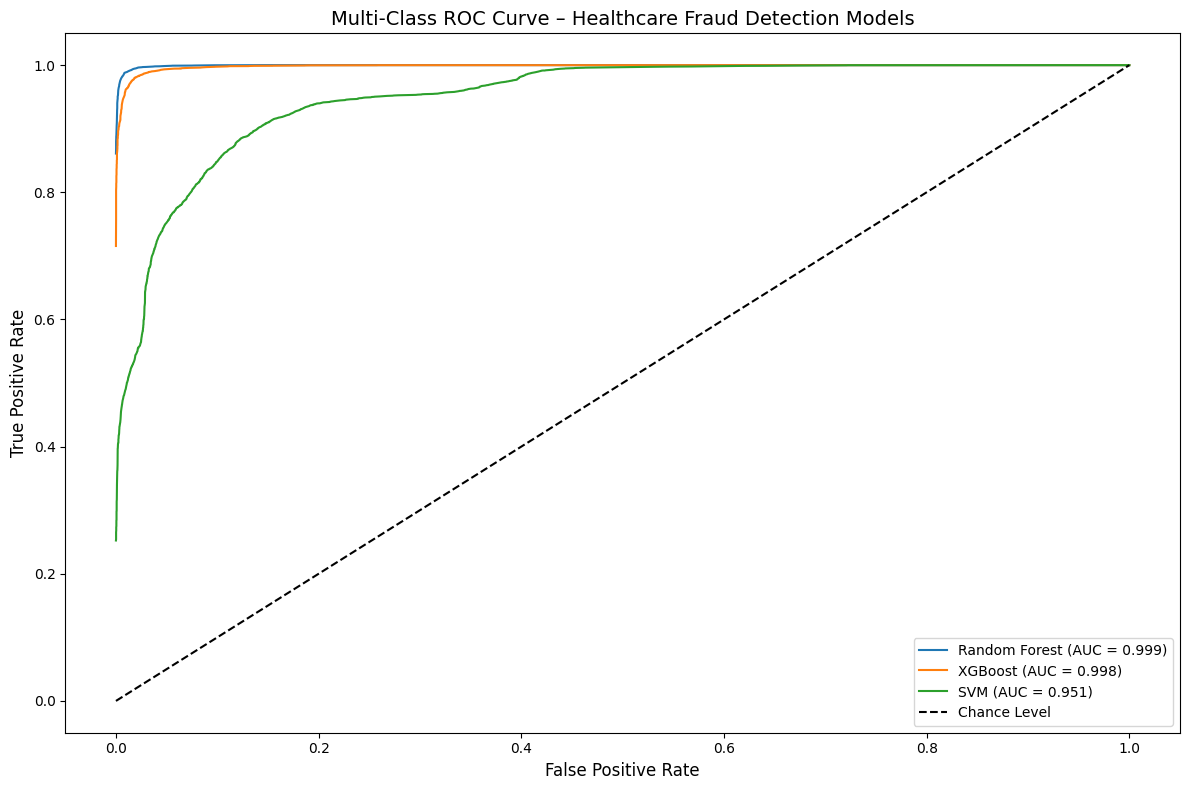

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Ensure clean white background
plt.style.use('default')

# ---- TRUE LABELS ----
y_true = y_test_hc
classes = np.unique(y_true)
n_classes = len(classes)

# ---- BINARIZE LABELS FOR MULTICLASS ROC ----
y_test_bin = label_binarize(y_true, classes=classes)

# ---- STORE ALL MODEL PROBABILITIES ----
models = {
    "Random Forest": y_pred_rf1_proba,        # you must define: rfc.predict_proba(X_test_hc)
    "XGBoost": pred_hc_proba,
    "SVM": pred_hc_svm_proba
}

plt.figure(figsize=(12, 8))

# ---- LOOP FOR EACH MODEL ----
for model_name, probs in models.items():
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{model_name} (AUC = {macro_auc:.3f})")

# ---- BASELINE ----
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")

# ---- LABELS & STYLE ----
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-Class ROC Curve – Healthcare Fraud Detection Models", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(False)
plt.tight_layout()

plt.show()


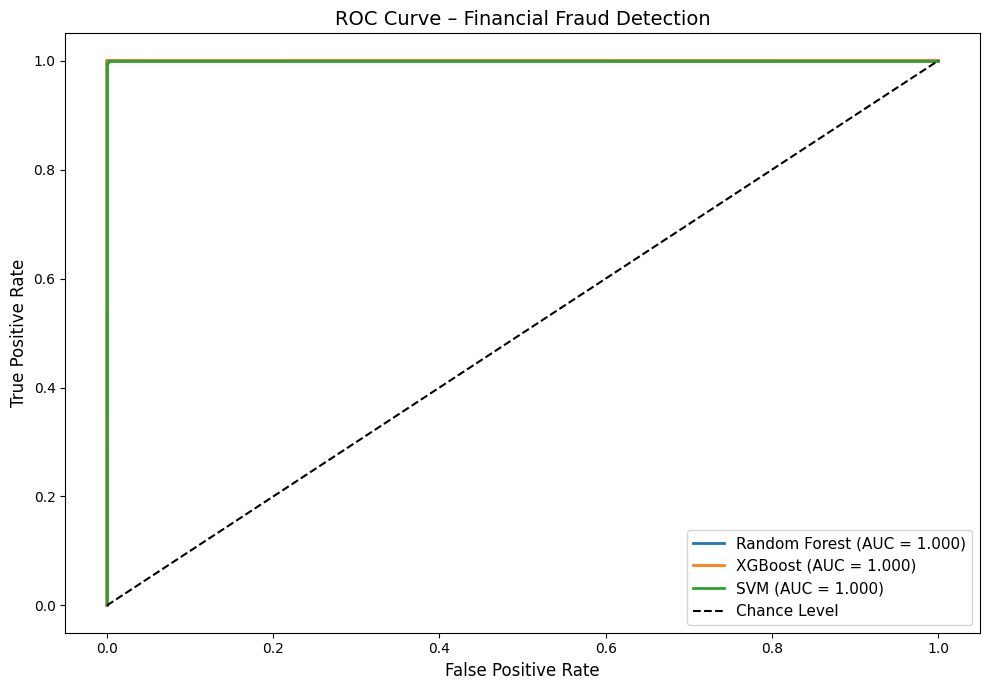

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.style.use("default")  # ensure white background

# --- Random Forest ---
fpr_rf, tpr_rf, _ = roc_curve(y_test_fin, pred_fin_rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)

# --- XGBoost ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_fin, pred_fin_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# --- SVM (LinearSVC uses decision_function) ---
fpr_svm, tpr_svm, _ = roc_curve(y_test_fin, pred_fin_svm_decision_scores)
auc_svm = auc(fpr_svm, tpr_svm)

# --- Plot ---
plt.figure(figsize=(10, 7))

plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve – Financial Fraud Detection", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(False)

plt.tight_layout()
plt.show()
